In [45]:
from pathlib import Path

import pandas as pd
from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from typing import List

import numpy as np

In [46]:
sns.set_style("whitegrid")

sns.set(
    font_scale=1.5,
    rc={
        "font.family": "sans-serif",
        "font.size": 16.0,
        "figure.figsize": (11.69, 8.27),
    }
)

tqdm.pandas()

In [47]:
# Data directories
data_dir = Path("../data")

raw_dir = data_dir / "raw"
pubmed_dir = raw_dir / "pubmed"
scite_dir = raw_dir / "scite"

processed_dir = data_dir / "processed"

results_dir = data_dir / "results"

In [48]:
def article_profiles(dois:List, pattern:str="mentions_norm_mean", norm_refs=False, norm_eng=False, ax=None) -> None:
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    scores = {}
    for doi in tqdm(dois):
        pdf = citation_patterns[citation_patterns.target==doi].copy()
        pdf = pdf.sort_values(pattern)
        
        if norm_refs:
            pdf["x_perc"] = pdf[pattern].rank(method="first") - 1
            pdf["x_perc"] = pdf["x_perc"] / pdf["x_perc"].max()
        else:
            pdf["x_perc"] = pdf[pattern].rank(method="first")
            
        if norm_eng:
            pdf[pattern] = pdf[pattern] / pdf[pattern].max()
        
        sns.lineplot(data=pdf, x="x_perc", y=pattern, zorder=1, ax=ax)
        sns.scatterplot(data=pdf, x="x_perc", y=pattern, size="mentions", ax=ax,
                        sizes=(20,200), legend=False, zorder=2, palette="Set2")
        
    ax.set_title(f"{len(dois)} DOIs")
    ax.set_xlabel("Citing Articles")
    ax.set_ylabel("Relative Engagement");

## Load data

In [51]:
metadata = pd.read_csv(processed_dir / "contexts.csv", index_col="doi")
mention_patterns = pd.read_csv(processed_dir / "mention_patterns.csv", index_col=0)
citation_patterns = pd.read_csv(processed_dir / "citation_patterns.csv", index_col=0)
article_patterns = pd.read_csv(processed_dir / "article_patterns.csv", index_col=0)

In [52]:
article_patterns["age"] = 2021 - metadata.year

In [59]:
col_names = {
    "refs_agg": "Ref count",
    "mentions_agg": "Mention count",
    "refs_norm_agg": "Frac. ref. count",
    "mentions_norm_agg": "Frac. mention count",
    "recite_1": "recitation_1",
    "recite_N": "recitation_N",
    "eng_norm_avg": "RTE-AVG",
    "consistency": "RTE-C",
    "age": "Publication age"
}

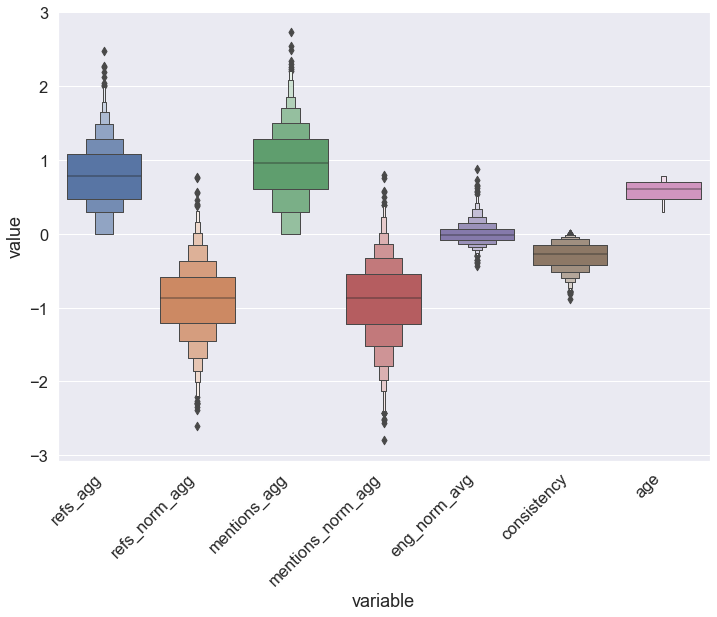

In [60]:
pdf = np.log10(article_patterns).melt()
sns.boxenplot(data=pdf, x="variable", y="value")
plt.xticks(rotation=45, ha="right");

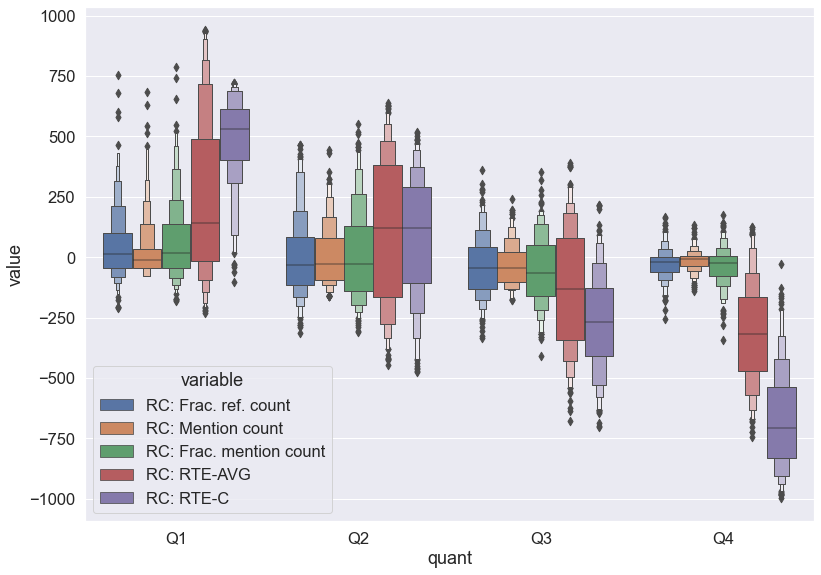

In [69]:
n_quantiles = 5
df = article_patterns.rename(columns=col_names)

base_var = col_names["refs_agg"]
count_methods = df.columns.tolist()
count_methods.remove(base_var)
count_methods.remove(col_names["age"])

df = df.rank()
for cm in count_methods:
    df["RC: " + cm] = df[cm] - df[base_var]

labels = [f"Q{_}" for _ in range(1, n_quantiles)]

pdf = df.reset_index()
pdf = pdf.join(pd.qcut(pdf[base_var], n_quantiles-1, duplicates="drop", labels=labels).to_frame("quant"))
pdf = pdf.melt(id_vars=["quant", "index"], value_vars=["RC: " + cm for cm in count_methods])

sns.boxenplot(data=pdf, hue="variable", y="value", x="quant")
plt.tight_layout()

In [70]:
cmap = sns.light_palette("green", as_cmap=True)
cmap = sns.diverging_palette(230, 20, as_cmap=True)

corr = (
    article_patterns
    .rename(columns=col_names)
    .corr(method="spearman")
)

corr.round(2)
# mask = np.triu(np.ones_like(corr, dtype=bool))

# sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})

# corr.style.background_gradient(cmap="vlag", low=corr.min().min())

,Ref count,Frac. ref. count,Mention count,Frac. mention count,RTE-AVG,RTE-C,Publication age
Ref count,1.00,0.89,0.93,0.85,0.24,-0.71,0.17
Frac. ref. count,0.89,1.00,0.83,0.95,0.21,-0.60,0.21
Mention count,0.93,0.83,1.00,0.89,0.49,-0.81,0.14
Frac. mention count,0.85,0.95,0.89,1.00,0.44,-0.68,0.19
RTE-AVG,0.24,0.21,0.49,0.44,1.00,-0.53,-0.02
RTE-C,-0.71,-0.60,-0.81,-0.68,-0.53,1.00,-0.12
Publication age,0.17,0.21,0.14,0.19,-0.02,-0.12,1.00


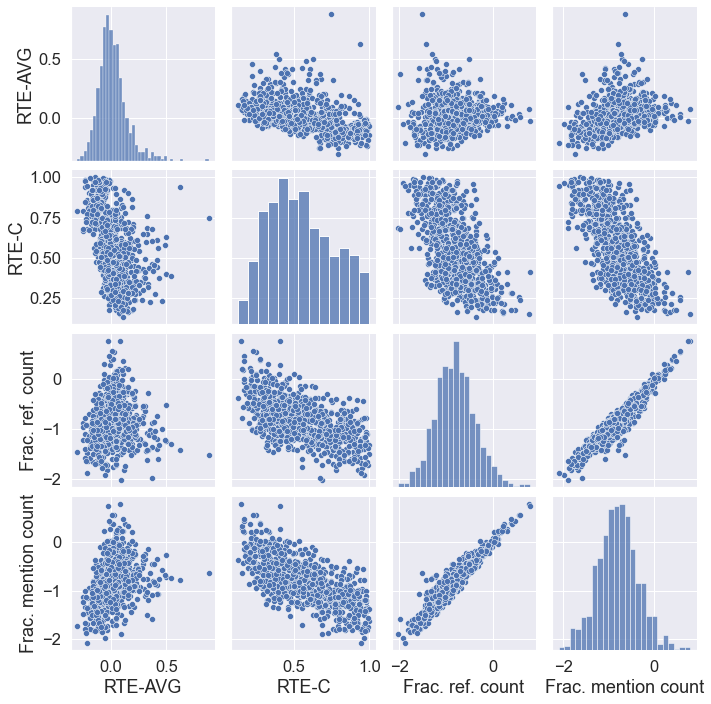

In [87]:
pdf = article_patterns.copy().replace(0, None).dropna()

log_cols = ["refs_agg", "mentions_agg", "refs_norm_agg", "mentions_norm_agg", "eng_norm_avg"]
for lc in log_cols:
    pdf[lc] = np.log10(pdf[lc])
pdf = pdf[["eng_norm_avg", "consistency", "refs_norm_agg", "mentions_norm_agg"]]
pdf = pdf.rename(columns=col_names)
g = sns.pairplot(pdf)

In [43]:
dois = article_patterns[
    (article_patterns.refs_agg>=10) &
    (article_patterns.eng_norm_avg>=.5)
].sample(5).index

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

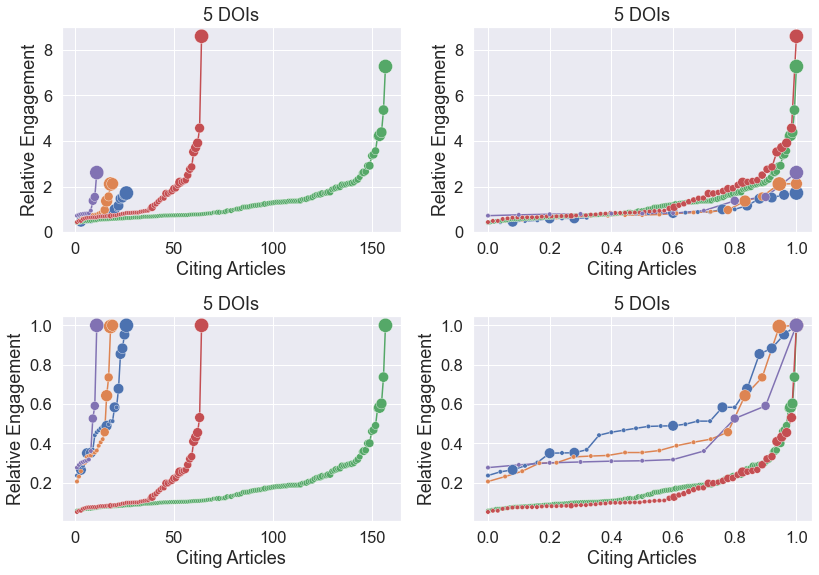

In [44]:
fig, axes = plt.subplots(2,2)

article_profiles(dois, norm_refs=False, ax=axes[0, 0])
article_profiles(dois, norm_refs=True, ax=axes[0, 1])
article_profiles(dois, norm_eng=True, ax=axes[1, 0])
article_profiles(dois, norm_refs=True, norm_eng=True, ax=axes[1, 1])

plt.tight_layout()

  0%|          | 0/49 [00:00<?, ?it/s]

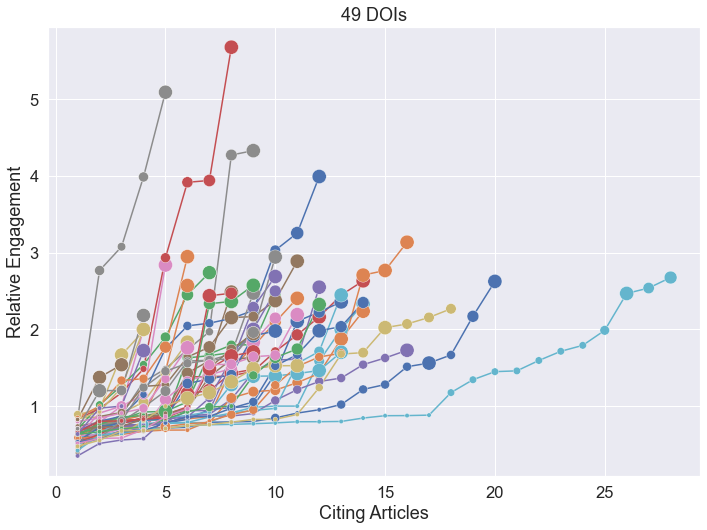

In [109]:
dois = article_patterns[
    (article_patterns.eng_norm_avg>=article_patterns.eng_norm_avg.quantile(.6)) &
    (article_patterns.refs_norm_agg>=article_patterns.refs_norm_agg.quantile(.6)) &
    (article_patterns.consistency>=article_patterns.consistency.quantile(.3))
].index

article_profiles(dois)

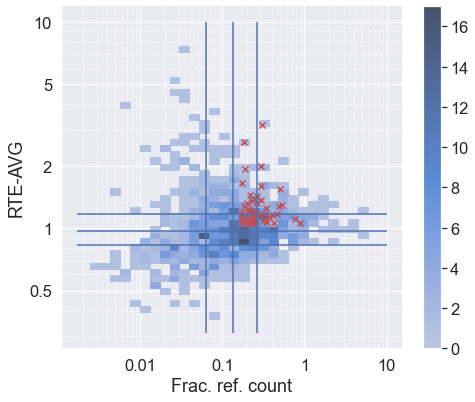

In [114]:
## Citations vs median weighted citation count
x = "refs_norm_agg"
y = "eng_norm_avg"

pdf = article_patterns.rename(columns=col_names)
sns.displot(data=pdf, x=col_names[x], y=col_names[y],
            log_scale=(True, True), cbar=True, height=6, aspect=1.2)

# Formatting
plt.grid(True, which="minor", ls="--", alpha=.7)
plt.grid(True, which="major", ls="-", linewidth=1.2)

xticks = [.01, .1, 1, 10]
plt.xticks(ticks=xticks, labels=xticks);

yticks = [.5, 1, 2, 5, 10]
plt.yticks(ticks=yticks, labels=yticks)

# plot percentiles
x0, x1 = plt.xlim()
y0, y1 = plt.ylim()

plt.hlines([article_patterns[y].quantile([.25, .5, .75])], x0, x1)
plt.vlines([article_patterns[x].quantile([.25, .5, .75])], y0, y1);

xs = article_patterns.loc[dois].refs_norm_agg
ys = article_patterns.loc[dois].eng_norm_avg

plt.scatter(xs, ys, marker="x", c="r");

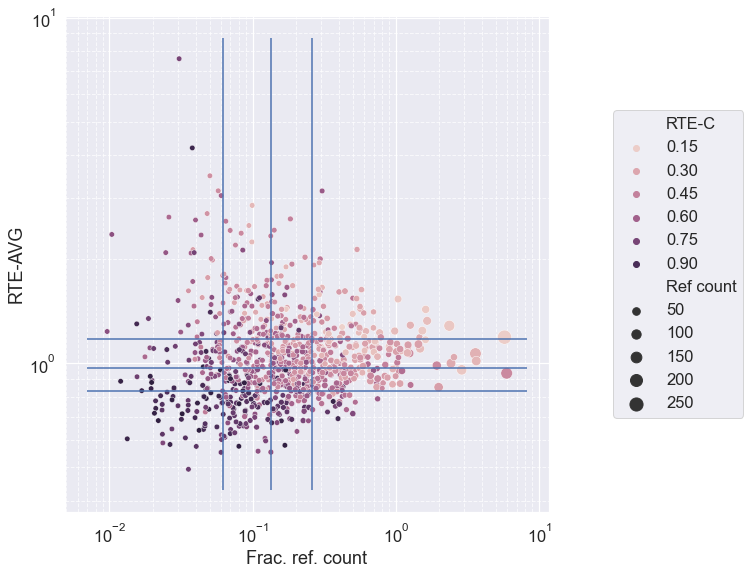

In [113]:
## Citations vs median weighted citation count
y = "eng_norm_avg"
x = "refs_norm_agg"
size = "refs_agg"
hue = "consistency"
# pdf["wf1_agg_log"] = np.log10(pdf["wf1_agg"])

pdf = article_patterns[article_patterns.refs_agg>=2]

sns.scatterplot(data=pdf.rename(columns=col_names),
                y=col_names[y],
                x=col_names[x],
                size=col_names[size],
                hue=col_names[hue], sizes=(30, 200)
               )
plt.legend(loc="right", bbox_to_anchor=(1.42, 0.5));

plt.grid(True, which="minor", ls="--", alpha=.7)
plt.grid(True, which="major", ls="-", linewidth=1.2)

# yticks = [1, 2, 5, 10, 20, 50, 100, 200]
# plt.yticks(ticks=yticks, labels=yticks)
# # xticks = [.5, 1,2,5,10]
# # plt.xticks(ticks=xticks, labels=xticks);

plt.loglog()

x0, x1 = plt.xlim()
y0, y1 = plt.ylim()

plt.hlines([article_patterns[y].quantile([.25, .5, .75])], x0, x1)
plt.vlines([article_patterns[x].quantile([.25, .5, .75])], y0, y1)

plt.tight_layout()

In [89]:
article_patterns.columns

Index(['refs_agg', 'refs_norm_agg', 'mentions_agg', 'mentions_norm_agg',
       'eng_norm_avg', 'consistency', 'age'],
      dtype='object')